In our radCAD model, traders will initiate a long position at timestep 0 with `trade_leverage_ratio` degree of leverage. Each timestep, the open trade will incur interest rate charges on any borrowed funds to finance the trade (ie if leverage is >1), and track running profit/loss based on the simulated price changes we will generate from the brownian_motion_generator repo.

This yields an expected Profit/Loss for each simulation, and we can compare expected results for different leverage ratios and borrowing costs. The benefit of using our simulated random walks is that we can run a Monte Carlo simulation on this simple trading system, to see what is likely to happen in a variety of cases.

For example, a higher leverage ratio may be more profitable *on average* up to a point vs a lower leverage ratio, but it will also get liquidated more often. Thus, we can optimize for more complex outcomes than simply maximizing profit - we can optimize for profit relative to risk for example.

This is especially relevant for protocol builders, which need to always consider what *may* happen and the relative risks, not just what is expected to happen *on average*. For example, USDT held its peg on the average day - but it's obviously meaningless to say a protocol "works on average" if it works 80% of the time but fatally explodes 20% of the time. In USDT's case, the system 's design had fatal flaws that analysts using techniques like Monte Carlo analysis identified were able to identify ahead of the crash. This doens't mean Monte Carlo can predict *when* a system will fail, but it can demonstrate if a failure is likely, and inevitable to eventually occur.

This simple tutorial contains the building blocks for extending to simulating and modeling risks for any protocols making use of collateral and/or leverage such as Maker DAO, Aave, and more.


In [1]:
import requests
import json
import pandas as pd
import numpy as np
from brownian_motion_generator import brownian_motion_generator as bmg

from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_theme(style="darkgrid")

In [2]:
#Fetch market prices for raw data
def coin_gecko_prices(coin, against='usd', days=1460):
    url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart?vs_currency={against}&days={days}'.format(coin,against,days) 
    r = requests.get(url)
    df = pd.DataFrame(r.json()['prices'],columns=['unix',f'{coin}_{against}'])
    return df

df = coin_gecko_prices('bitcoin')
latest_market_price = df.tail(1)['bitcoin_usd'].values[0]
df


,unix,bitcoin_usd
0,1550102400000,3610.062273
1,1550188800000,3589.661830
2,1550275200000,3601.229191
3,1550361600000,3622.591653
4,1550448000000,3665.075531
...,...,...
1456,1675900800000,22947.507829
1457,1675987200000,21820.886508
1458,1676073600000,21630.132980
1459,1676160000000,21889.432080


In [3]:
#Generate random walks of prices

TIMESTEPS = 30
RUNS = 1_000

#Series should be mean stationary. So in this case of price series, convert them to log normal returns
df['btc_ln_return'] = np.log(df['bitcoin_usd'] / df['bitcoin_usd'].shift(1))
df = df.dropna(how='any')

#Approximate the distribution parameters of each series
#Here we will use a custom distribution for each: other options include 'normal' or 'laplace'
OU_params_btc = bmg.estimate_OU_params(df['btc_ln_return'].values, distribution_type='custom')

# OPTIONALLY: override the gamma (long term mean) of the expected distribution
#For example if you wanted to ignore the historical trend in prices you could do so by setting price changes to 0 gamma
OU_params_btc.gamma = 0

OU_params = (
    OU_params_btc,
)

correlations = df[
    ['btc_ln_return',
    ]
].corr().values[0]

OU_procs = bmg.simulate_corr_OU_procs(TIMESTEPS, OU_params, RUNS, rho=correlations)
OU_procs.shape


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13247.71it/s]


(1000, 30, 1)

In [4]:
#Turn the numpy array into a dataframe
runs,timesteps,procs = OU_procs.shape
OU_procs_arr = np.column_stack((np.repeat(np.arange(runs),timesteps),OU_procs.reshape(runs*timesteps,-1)))
walks = pd.DataFrame(OU_procs_arr,
                     columns=[
                         'run',
                         'btc_ln_return',
                     ])

walks['run'] = walks['run'].astype('int') + 1
walks['timestep'] = walks.groupby('run').cumcount() + 1

#Then turn this into a dictionary with keys of (run,timestep) to easily query the simulated return at a given run,timestep
walks = walks.set_index(['run','timestep']).to_dict('index')


Now it's time to setup our radCAD model, which will use the `walks` variable set above as the source of stochastic randomness for price movements.


In [5]:
system_params = {
    'trade_leverage_ratio': [1,2,5,10], #1 means no leverage. A floor is set in policy functions so 1 is smallest possible value
    'risk_level_liquidation': [1.1], #liquidated if Total Assets / (Borrowed Value + Accrued Interest) is < this
    'daily_borrowing_rate': [0.0002], #in APR. ie 0.0002 is equal to 0.02% per day, or 7.3% per year (0.02% * 365)
}

initial_state = {
    'asset_price': latest_market_price,
    'running_pnL': 0, #tracks cumulative profit and loss on the position
    'usd_borrowed': 0,
    'accrued_interest': 0,
    'is_liquidated': False,
    'subset_params': None

}


In [6]:
#Substep 1
def p_borrow_usd(params, substep, state_history, prev_state, **kwargs):
    borrow_usd = initial_state['asset_price'] * (max(1,params['trade_leverage_ratio']) - 1)
    return {'borrow_usd': borrow_usd}

def s_usd_borrowed(params, substep, state_history, prev_state, policy_input, **kwargs):
    return ('usd_borrowed', policy_input['borrow_usd'])


#Substep 2
def p_accrue_interest(params, substep, state_history, prev_state, **kwargs):
    if prev_state['is_liquidated']:
        accrue_interest = 0
    else:
        accrue_interest = prev_state['usd_borrowed'] * params['daily_borrowing_rate']
    return {'accrue_interest': accrue_interest}

def s_accrued_interest(params, substep, state_history, prev_state, policy_input, **kwargs):
    updated_accrued_interest = prev_state['accrued_interest'] + policy_input['accrue_interest']
    return ('accrued_interest', updated_accrued_interest)

def p_update_price(params, substep, state_history, prev_state, **kwargs):
    run = prev_state['run']
    timestep = prev_state['timestep']
    pct_price_change = np.exp(walks[(run, timestep)]['btc_ln_return'])
#     pct_price_change = .50
    return {'pct_price_change': pct_price_change}

def s_asset_price(params, substep, state_history, prev_state, policy_input, **kwargs):
    updated_asset_price = prev_state['asset_price'] * policy_input['pct_price_change']
    return ('asset_price', updated_asset_price)


#Substep 3

def p_update_running_pnL(params, substep, state_history, prev_state, **kwargs):
    if prev_state['is_liquidated']:
        leveraged_pnL = prev_state['running_pnL']
    else:
        unleveraged_pnL = prev_state['asset_price'] - initial_state['asset_price']
        leveraged_pnL = unleveraged_pnL * max(1,params['trade_leverage_ratio'])
    return {'leveraged_pnL': leveraged_pnL}

def s_running_pnL(params, substep, state_history, prev_state, policy_input, **kwargs):
    return ('running_pnL', policy_input['leveraged_pnL'])

def p_check_liquidated(params, substep, state_history, prev_state, **kwargs):
    total_assets = max(1,params['trade_leverage_ratio']) * prev_state['asset_price']
    total_liabilities = prev_state['usd_borrowed'] + prev_state['accrued_interest']
    
    if total_liabilities == 0:
        liquidated = False
    elif total_assets / total_liabilities > params['risk_level_liquidation']:
        liquidated = False
    else:
        liquidated = True
    return {'is_liquidated': liquidated}

def s_is_liquidated(params, substep, state_history, prev_state, policy_input, **kwargs):
    return ('is_liquidated', policy_input['is_liquidated'])
    

In [7]:
state_update_blocks = [
    {
        'policies': {
            'borrow_funds': p_borrow_usd,
        },
        'variables': {
            'usd_borrowed': s_usd_borrowed,
        }
    },
    {
        'policies': {
            'accrue_interest': p_accrue_interest,
            'update_price': p_update_price,
        },
        'variables': {
            'accrued_interest': s_accrued_interest,
            'asset_price': s_asset_price,
        }
    },
    {
        'policies': {
            'update_pnL': p_update_running_pnL,
            'check_liquidated': p_check_liquidated,
        },
        'variables': {
            'running_pnL': s_running_pnL,
            'is_liquidated': s_is_liquidated,
        }
    },
]


In [8]:
model = Model(initial_state=initial_state, state_update_blocks=state_update_blocks, params=system_params)
simulation = Simulation(model=model, timesteps=TIMESTEPS, runs=RUNS)
experiment = Experiment([simulation])

# Select the Pathos backend to avoid issues with multiprocessing and Jupyter Notebooks
# NOTE: Using the `return_parameters` setting requires this pull request: https://github.com/CADLabs/radCAD/pull/62
experiment.engine = Engine(drop_substeps=True, return_parameters=True)#backend=Backend.PATHOS)

result = experiment.run()
df = pd.DataFrame(result)
df['total_return_pct'] = ((df['running_pnL'] - df['accrued_interest']) / latest_market_price) * 100
df

,asset_price,running_pnL,usd_borrowed,accrued_interest,is_liquidated,subset_params,simulation,subset,run,substep,timestep,trade_leverage_ratio,risk_level_liquidation,daily_borrowing_rate,total_return_pct
0,22066.268763,0.000000,0.000000,0.000000,False,None,0,0,1,0,0,1,1.1,0.0002,0.000000
1,22066.268763,0.000000,0.000000,0.000000,False,None,0,0,1,3,1,1,1.1,0.0002,0.000000
2,22195.930510,129.661748,0.000000,0.000000,False,None,0,0,1,3,2,1,1.1,0.0002,0.587602
3,22309.443911,243.175149,0.000000,0.000000,False,None,0,0,1,3,3,1,1.1,0.0002,1.102022
4,22383.874578,317.605815,0.000000,0.000000,False,None,0,0,1,3,4,1,1.1,0.0002,1.439327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123995,16487.232670,-1795.410294,198596.418863,436.912121,True,None,0,3,1000,3,26,10,1.1,0.0002,-10.116447
123996,16243.564549,-1795.410294,198596.418863,436.912121,True,None,0,3,1000,3,27,10,1.1,0.0002,-10.116447
123997,16671.864749,-1795.410294,198596.418863,436.912121,True,None,0,3,1000,3,28,10,1.1,0.0002,-10.116447
123998,16815.930950,-1795.410294,198596.418863,436.912121,True,None,0,3,1000,3,29,10,1.1,0.0002,-10.116447


In [9]:
#Calculate the range of outcomes for a given trade_leverage_ratio
trade_leverage_ratio = 5
data = df[(df['trade_leverage_ratio'] == trade_leverage_ratio) & (df['timestep'] == TIMESTEPS)]
data['total_return_pct'].describe()


count    1000.000000
mean        7.794267
std        66.137926
min       -81.748790
25%       -48.166430
50%        -0.754937
75%        48.329897
max       352.588851
Name: total_return_pct, dtype: float64

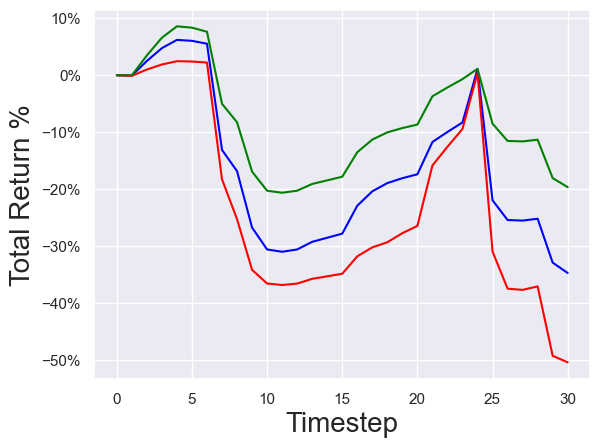

In [10]:
#Chart the range of profitability of any given run, across different trade_leverage_ratio
#25th percentile, mean, and 75th percentile
run = 1

data = df[df['run'] == run]

data = data.groupby('timestep').agg(
    Mean=('total_return_pct', 'mean'),
    Percentile_25=('total_return_pct', lambda x: x.quantile(.25)),
    Percentile_75=('total_return_pct', lambda x: x.quantile(.75)),
).reset_index()

step = data['timestep']
p = sns.lineplot(x=step, y=data['Mean'], color='blue')
p = sns.lineplot(x=step, y=data['Percentile_25'], color='red')
p = sns.lineplot(x=step, y=data['Percentile_75'], color='green')

p.set_ylabel('Total Return %', fontsize = 20)
p.set_xlabel("Timestep", fontsize = 20)
p.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()


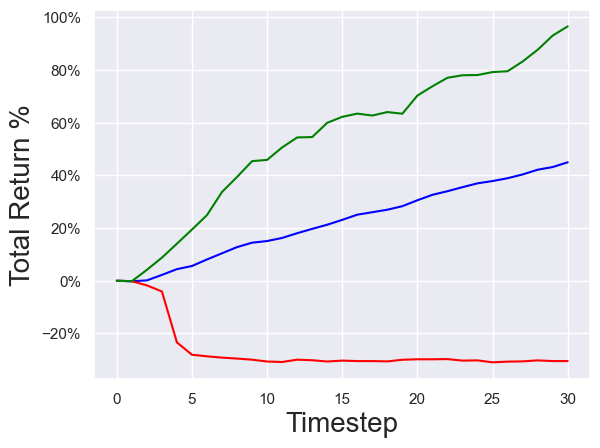

In [11]:
#Chart the range of profitability of any given subset of trade_leverage_ratio, across different runs
#25th percentile, mean, and 75th percentile
trade_leverage_ratio = 10

data = df[df['trade_leverage_ratio'] == trade_leverage_ratio]

data = data.groupby('timestep').agg(
    Mean=('total_return_pct', 'mean'),
    Percentile_25=('total_return_pct', lambda x: x.quantile(.25)),
    Percentile_75=('total_return_pct', lambda x: x.quantile(.75)),
).reset_index()

step = data['timestep']
p = sns.lineplot(x=step, y=data['Mean'], color='blue')
p = sns.lineplot(x=step, y=data['Percentile_25'], color='red')
p = sns.lineplot(x=step, y=data['Percentile_75'], color='green')

p.set_ylabel('Total Return %', fontsize = 20)
p.set_xlabel("Timestep", fontsize = 20)
p.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()
